# OpenFASoC: Digital LDO Generator

<a href="https://colab.research.google.com/github/idea-fasoc/OpenFASOC/blob/main/docs/source/notebooks/ldo-gen/LDO_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
OpenFASOC Team, November 2022
SPDX-License-Identifier: Apache-2.0
```


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Ali Hammoud (Lead) <br /> Email ID: alibilal@umich.edu|University of Michigan|Yes|No|
|Pranav Lulu <br /> Email ID: pranavl@umich.edu | University of Michigan|No|No


Welcome!
This notebook[^1] serves as an introduction to the LDO generator: an open-source silicon generator part of [OpenFASoC](https://github.com/idea-fasoc/OpenFASOC) - An open-source framework for autonomous generation of Digital LDO. A cell-based design methodology is employed to allow full synthesizability and compatibility with computer-aided designs (CADs) flow and advanced technology nodes. Furthermore, the generator automates the design flow end-to-end in Python and supports designing completely with open-source CAD tools.

**_Index Terms:_** Circuit generator , open source, synthesizable design, digital LDO.

Citation: Tutu Ajayi et al., "An Open-source Framework for Autonomous SoC Design with Analog Block Generation," 2020 IFIP/IEEE 28th International Conference on Very Large Scale Integration (VLSI-SOC), 2020, pp. 141-146.


[^1]: This notebook is targeted at users of all professional backgrounds aiming to learn how to *code* their chips. The goal is to go through all the steps of generating the LDO and an overview of the simulation results. 

## Digital LDO
Digital LDO allows for completely digital custom voltage operation in a design that can be inserted quickly into a larger digital project. The Digital LDO consists of a reference voltage generator, comparator, digital controller, and an array of power switches. 

The function of the LDO is to ensure the VREG output remains at a stable value equal to the reference voltage VREF. The input voltage VIN can be connected to VDD or another voltage source and is used to drive the output VREG. Output capacitors ensure that VREG remains smooth during sudden load shifts.
The reference voltage (VREF) is generated through digital “trim” inputs to the LDO. These trim inputs can be used to tune the reference (and thus desired output voltage) between 1.8V - 3.3V.

The comparator receives the reference voltage and compares the two voltages VREF and VREG in a feedback process. The CMOS comparator is implemented as a clocked (dynamic) latched (holds result) comparator. This allows for relatively low power usage and will produce digital output each clock period. A digital signal carrying comparison information is then sent to the digital control logic. A comparator output low indicates that the VREG value is lower than the reference voltage VREF value. On the other hand, a comparator output high indicates that VREG is at higher voltage than VREF. 

The full LDO RTL diagram is included here to better illustrate the design: 

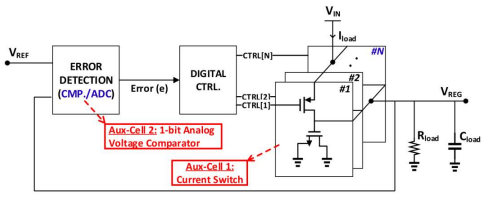

The digital controller then receives the comparator information and adjusts the settings of each of the PMOS switches in the power array. The output of the controller is a register which has size bits = number of PMOS switches in the power array. Initially, all control bits in the output register are set to a reset value (all high values) “1” in order to turn off all PMOS switches. The controller responds to inputs by shifting all control bits in the output register, then entering an additional high "1" voltage to turn off one more power switch, or an additional low "0" voltage to turn on one more power switch. 

To better illustrate the task of the controller, an input/output controller diagram is included below:

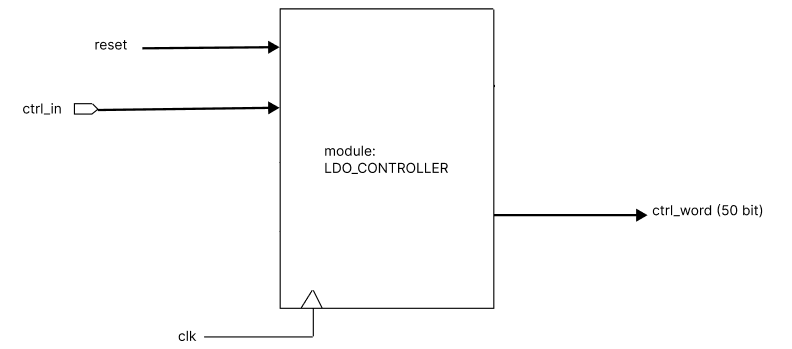

This feedback cycle repeats each clock period. The power PMOS transistors act like current switches. Each additional current switch allows some additional current to flow from VIN to VREG, thus increasing the voltage value of VREG. Turning off a current switch decreases the voltage value of VREG.

The above description addresses the full functioning of the LDO. See below for a detailed discussion of the open-source automated flow.

## Generator Flow
The LDO applies the below described process to translate a specification into a circuit GDS. 

Before beginning, we must set up our python environment with the necessary open-source tools. The generator uses a flexible set of tools and will support even more in the future. In the below flow walkthrough, we will use:
*   Yosys for logic synthesis
*   Openroad for placing and routing
*   Klayout to produce the final GDS file
*   Magic for DRC and LVS checks as well as PEX
*   Ngspice for simulation

There may be a restart runtime warning after this code block, but disregard.


In [ ]:
# install all tools and dependencies
import os
import pathlib
import sys

!pip install matplotlib pandas pyinstaller
!apt-get install -y ruby-full time build-essential
!apt install -f libqt4-designer libqt4-xml libqt4-sql libqt4-network libqtcore4 libqtgui4
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        netgen \
                        openroad \
                        yosys
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click svgutils ngspice

!wget https://www.klayout.org/downloads/Ubuntu-18/klayout_0.27.11-1_amd64.deb
!dpkg -i klayout_0.27.11-1_amd64.deb

# clone OpenFASOC repo
!git clone https://github.com/alibillalhammoud/OpenFASOC
# setup env
OPENFASOC_ROOT=str(pathlib.Path('OpenFASOC').resolve())
LDO_ROOT=OPENFASOC_ROOT+"/openfasoc/generators/ldo-gen/"
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env OPENFASOC_ROOT={OPENFASOC_ROOT}
%env PATH={PATH}:{OPENFASOC_ROOT}:{OPENFASOC_ROOT}/openfasoc/generators/temp-sense-gen/tools
# GDS files
!cp OpenFASOC/openfasoc/generators/ldo-gen/blocks/sky130hvl/gds/capacitor_test_nf.gds OpenFASOC/docs/source/notebooks/ldo-gen
!cp OpenFASOC/openfasoc/generators/ldo-gen/blocks/sky130hvl/gds/PMOS.gds OpenFASOC/docs/source/notebooks/ldo-gen
!cp OpenFASOC/openfasoc/generators/ldo-gen/blocks/sky130hvl/gds/PT_UNIT_CELL.gds OpenFASOC/docs/source/notebooks/ldo-gen
!cp OpenFASOC/openfasoc/generators/ldo-gen/blocks/sky130hvl/gds/vref_gen_nmos_with_trim.gds OpenFASOC/docs/source/notebooks/ldo-gen
!cp OpenFASOC/openfasoc/generators/ldo-gen/blocks/sky130hvl/gds/LDO_COMPARATOR_LATCH.gds OpenFASOC/docs/source/notebooks/ldo-gen
# scripts
!cp OpenFASOC/docs/source/notebooks/aux_files/def2gds.py OpenFASOC/docs/source/notebooks/ldo-gen
!cp OpenFASOC/docs/source/notebooks/aux_files/dbtodef.tcl OpenFASOC/docs/source/notebooks/ldo-gen
# setup info
!cp OpenFASOC/openfasoc/common/platforms/sky130hvl/gds/sky130_fd_sc_hvl.gds OpenFASOC/docs/source/notebooks/ldo-gen
!cp OpenFASOC/openfasoc/common/platforms/sky130hvl/fill.json OpenFASOC/docs/source/notebooks/ldo-gen

# pip3 packages
!apt install python3-pip
!pip3 install matplotlib pandas pyinstaller ipykernel cairosvg pillow

### Understanding User Input
The generator must first parse the user’s requirements into a high-level circuit description or verilog. Note that verilog is a circuit description type that uses theoretical constructs (like mathematical operators, if-else blocks, always @ blocks,... etc) to concisely describe circuits. User input parsing is implemented by reading from a JSON spec file directly in the ldo-gen repository. The JSON allows for specifying voltage and maximum load current (imax). The example we are using here runs the sky130 node, and we already have a model file for this node. The generator uses this model file to automatically determine the number of power transistors , among other necessary modifications that can be made to meet spec. The generator references the model file in an iterative process until either meeting spec or failing. A verilog description is then produced by substituting specifics into several template verilog files.

You can see this solve and verilog generation by running the code below and exploring the temp-sense-gen/src folder in your python virtual environment:


In [ ]:
!cd OpenFASOC/openfasoc/generators/ldo-gen && make sky130hvl_ldo_verilog

### Logic Synthesis
At this phase, the implementation of fundamental components — such as transistors and resistors — is not considered. Logic synthesis takes the verilog description from the previous step and outputs a more detailed netlist by parsing theoretical verilog constructs like always, case, if-else, operator, etc… blocks. Note that a netlist is just a list of pins and component connections. Additionally the entire description is consolidated into one file (not considering the node specific library files we will need later) which means that the low and high voltage components are correctly connected. Specifics such as the shapes, placement, length, size of wires and components, along with power connections are still not considered. 

You can see the synthesis step by running the code below and viewing the ldo-gen/flow/results/sky130hvl/ldo/base/1_synth.v file in your python virtual environment:

In [ ]:
!cd OpenFASOC/openfasoc/generators/ldo-gen/flow && make synth

### Automatic Place and Route
Now that we have a description of our circuit which includes specific connections and components to use, it is possible to consider drawing the wires, placing the components, and choosing materials. Below is a step-by-step visual breakdown of the openroad APR.

#### Floorplan
First, an outline of the circuit is created encompassing the area that the circuit will occupy and including all the input and output pins for the top level circuit. Inside the temperature sensor, power rails, tap, and decap cells are placed. The tap and decap cells serve to address manufacturing and real-world circuit performance concerns. Within the box, a grid is formed with rows of fixed height.

Run floorplan and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/ldo-gen/flow && make floorplan

In [ ]:
import gdstk
import os
import IPython.display
import svgutils.transform as sg
# work dir setup
!cp OpenFASOC/openfasoc/generators/ldo-gen/flow/results/sky130hvl/ldo/base/2_floorplan.odb OpenFASOC/docs/source/notebooks/ldo-gen
os.environ['from_oprd_'] = '2_floorplan.odb'
os.environ['to_oprd_'] = 'out2.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/ldo-gen && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/ldo-gen && klayout -zz -rd design_name=ldoInst \
	        -rd in_def="out2.def" \
	        -rd in_gds="PMOS.gds PT_UNIT_CELL.gds vref_gen_nmos_with_trim.gds LDO_COMPARATOR_LATCH.gds capacitor_test_nf.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out2.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/ldo-gen/out2.gds /content
flrpln = gdstk.read_gds("out2.gds".format(LDO_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out2.svg')
fig = sg.fromfile('out2.svg')
fig.set_size(('700','700'))
fig.save('out2.svg')
IPython.display.SVG('out2.svg')

####Place
Within the rows (visualized in the run above) the standard cells are placed. Cells are building block circuits that, when combined, implement the bulk of temperature sensor functionality. These standard components include: inverters or other logic gates, comparator (used to find error VREF vs VREG), etc. 

Run place and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/ldo-gen/flow && make place

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
from cairosvg import svg2png
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
# work dir setup
!cp OpenFASOC/openfasoc/generators/ldo-gen/flow/results/sky130hvl/ldo/base/3_place.odb OpenFASOC/docs/source/notebooks/ldo-gen
os.environ['from_oprd_'] = '3_place.odb'
os.environ['to_oprd_'] = 'out3.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/ldo-gen && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/ldo-gen && klayout -zz -rd design_name=ldoInst \
	        -rd in_def="out3.def" \
	        -rd in_gds="PMOS.gds PT_UNIT_CELL.gds vref_gen_nmos_with_trim.gds LDO_COMPARATOR_LATCH.gds capacitor_test_nf.gds sky130_fd_sc_hvl.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out3.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/ldo-gen/out3.gds /content
flrpln = gdstk.read_gds("out3.gds".format(LDO_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out3.svg')
fig = sg.fromfile('out3.svg')
fig.set_size(('700','700'))
fig.save('out3.svg')
fname = "out3"
svg2png(url=fname+".svg",write_to=fname+".png")
plt.figure(figsize=(10,10),dpi=80)
img = mpimg.imread(fname+".png")
plt.imshow(img) 
plt.show()

#### CTS
CTS stands for clock tree synthesis (balancing a clock delay to all parts of a circuit); We do not require this in the temperature sensor, but we do require the filler cells which are placed by openroad during CTS. Filler cells are exactly what they sound like. There are many large gaps (see the above run graphic) within each row, between components. These gaps must be filled such that there are continous silicon p and n wells — among other manufacturing and performance reasons. Fillers are placed to fill the gaps.

Run CTS and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/ldo-gen/flow && make cts

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
from cairosvg import svg2png
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
# work dir setup
!cp OpenFASOC/openfasoc/generators/ldo-gen/flow/results/sky130hvl/ldo/base/4_cts.odb OpenFASOC/docs/source/notebooks/ldo-gen
os.environ['from_oprd_'] = '4_cts.odb'
os.environ['to_oprd_'] = 'out4.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/ldo-gen && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/ldo-gen && klayout -zz -rd design_name=ldoInst \
	        -rd in_def="out4.def" \
	        -rd in_gds="PMOS.gds PT_UNIT_CELL.gds vref_gen_nmos_with_trim.gds LDO_COMPARATOR_LATCH.gds capacitor_test_nf.gds sky130_fd_sc_hvl.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out4.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/ldo-gen/out4.gds /content
flrpln = gdstk.read_gds("out4.gds".format(LDO_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out4.svg')
fig = sg.fromfile('out4.svg')
fig.set_size(('700','700'))
fig.save('out4.svg')
fname = "out4"
svg2png(url=fname+".svg",write_to=fname+".png")
plt.figure(figsize=(10,10),dpi=80)
img = mpimg.imread(fname+".png")
plt.imshow(img) 
plt.show()

####Routing
The last step is to connect the components. During routing, wire-like pathways known as traces are placed in the design.

Run route and finish then render a graphic by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/ldo-gen/flow && make finish

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
from cairosvg import svg2png
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
!cp OpenFASOC/openfasoc/generators/ldo-gen/flow/results/sky130hvl/ldo/base/6_final.gds /content
flrpln = gdstk.read_gds("6_final.gds".format(LDO_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('6_final.svg')
fig = sg.fromfile('6_final.svg')
fig.set_size(('700','700'))
fig.save('6_final.svg')
fname = "6_final"
svg2png(url=fname+".svg",write_to=fname+".png")
plt.figure(figsize=(10,10),dpi=80)
img = mpimg.imread(fname+".png")
plt.imshow(img) 
plt.show()

### DRC and LVS
Now that the generator has completed the flow, an automatic checking process is initiated. DRC or design rule checking ensures that the final circuit obeys manufacturing rules. Rules are set by the foundry for each of their nodes. LVS or layout vs schematic will compare the final output from APR to the netlist that we gave the APR tool (in this case Openroad). This ensures that APR ran correctly and our final circuit matches our netlist description from logic synthesis. Both of these steps will use magic (LVS will also run on magic).

Run checks by executing the below code. Both checks will give command line output below with complete status:

In [ ]:
!cd OpenFASOC/openfasoc/generators/ldo-gen/flow && make magic_drc
!cd OpenFASOC/openfasoc/generators/ldo-gen/flow && make netgen_lvs

## Simulations
To see how the final design functions, run simulations by executing the code block below.

The first simulation is a solving process for the max load current. The simulation script finds the largest load such that the VREG is maintained near VREF.

The second simulation is a transient behavior simulation which shows (from 0 voltage) how VREG is increased to VREF. This also reveals transient effects (such as overshoot in the feedback). Scroll down in the output to view plots.

**_Note:_** This may take over 30 minutes.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
!cd /content/OpenFASOC/openfasoc/generators/ldo-gen && python ./tools/ldo-gen.py --specfile test.json --output ./work --platform sky130hvl --mode sim

plt.figure(figsize=(10,10),dpi=80)
plt.axis('off')
img = mpimg.imread("/content/OpenFASOC/openfasoc/generators/ldo-gen/work/vregplot.png")
plt.imshow(img)
plt.show()
plt.figure(figsize=(10,10),dpi=80)
plt.axis('off')
img2 = mpimg.imread("/content/OpenFASOC/openfasoc/generators/ldo-gen/work/currentplot.png")
plt.imshow(img2)
plt.show()